In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
from lib import get_stop_words, get_text, get_lem_words
from multiprocessing import Pool
from itertools import repeat, chain
import pickle

In [3]:
NUM_PROCESSES = 20

In [4]:
# project gutenberg text has a lot of extra stuff at the beginning and end
def get_text_no_gutenberg(raw_text):
    return re.split('^\*\*\*(.*)\*\*\*$', raw_text, flags=re.MULTILINE)[2]
    
def remove_single_letter(text):
    text = re.sub(r'\b\w\b', ' ', text)
    return text

# split the raw text into chapters
def split_chapters(text, roman_numeral=True):
    if roman_numeral:
        return re.split(r'(^\s?CHAPTER [IVXLCDM]+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)
    else:
        return re.split(r'(^\s?CHAPTER \d+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)

# sometimes the contents lists chapters that are in table of contents. here we just remove chapters that are too short.
# here we also delete the first chapter, which is just the table of contents and preface
def chapter_longer_than(raw_chapters, n=150):
    return list(filter(lambda c: len(c) > n, raw_chapters))

# split remove stopwords
def remove_stopwords(text, stopwords):
    return re.sub(r'\b(' + '|'.join(stopwords) + r')\b', '', text)

def expand_apostrophe_s(text):
    return re.sub(r"(\w)'s", r"\1 is", text)

# theres a ton of whitespace that we dont want
def remove_extra_spaces(text):
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def replace_common_dots(text):
    text =  re.sub(r'dr\.', 'dr ', text)
    text =  re.sub(r'mr\. ', 'mr ', text)
    return text

def compress_abbr(text):
    pattern = r'\b(?:[a-zA-Z]\.){2,}\b.*?'
    matches = re.finditer(pattern, text, re.MULTILINE | re.IGNORECASE)
    abbr = set(map(lambda m: m.group(), matches))
    for a in abbr:
        text = text.replace(a, a.replace('.', ''))
    return text

def get_lem(fn):
    lem = {}
    lem_regex = []
    with open(fn, 'r', encoding='utf-8-sig') as f:
        for i in f:
            text = [j for j in i.lower().split()]
            if text[0] not in lem:
                lem[text[0]] = [text[1]]
            else:
                lem[text[0]].append(text[1])
    for word, lemmas in lem.items():
        lem_regex.append([word, fr'\b({"|".join(lemmas)})\b'])
    return lem_regex
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', lambda m: "." if m.group(0) == "." else " ", text)
    return text

def split_sentences(text):
    return re.split(r"[.]", text)

def lemmatization(text, lem):
    for lemma, lem_regex in lem:
        text = re.sub(lem_regex, lemma, text)
    return text

def trim(text):
    for i in range(len(text)):
        text[i] = text[i].strip()
    return text

In [5]:
books = [
    {
        'fn': 'a-study-in-scarlet.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-valley-of-fear.txt',
        'roman_numeral': False,
        'remove_first_chapter': True
    },
    {
        'fn': 'the-hound-of-the-baskervilles.txt',
        'roman_numeral': False,
        'remove_first_chapter': True,
    },
    {
        'fn':  'the-mystery-of-cloomber.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-sign-of-four.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
]

In [6]:
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')
book_i = 2
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']


def clean_by_chapter(raw_chapter, stop_words, lem):
    raw_chapter = remove_extra_spaces(raw_chapter)
    raw_chapter = replace_common_dots(raw_chapter)
    raw_chapter = compress_abbr(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)
    raw_chapter = expand_apostrophe_s(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)
    raw_chapter = remove_punctuation(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)
    raw_chapter = remove_stopwords(raw_chapter, stop_words)
    raw_chapter = lemmatization(raw_chapter, lem)
    raw_chapter = remove_extra_spaces(raw_chapter)
    return raw_chapter


def clean_all_text(book_fn, base_dir, stop_words, lem, book_rom_num, remove_first_chapter):

    # get the raw text and make it all lower case
    raw_text = get_text(book_fn, base_dir)
    raw_text = raw_text.lower()
    raw_text = get_text_no_gutenberg(raw_text)

    # split into chapters so we can parallelize all of the text operations
    raw_chapters = split_chapters(raw_text, book_rom_num)

    # keep only the chapter's texts and none of the preface and content info
    longer_than_n = list(map(lambda c: len(c) > 100, raw_chapters))
    longer_than_n[0] = longer_than_n[0] if not remove_first_chapter else False
    chapt_start = next(i for i,v in enumerate(longer_than_n) if v)
    raw_chapters = raw_chapters[chapt_start::2]

    # map the cleaning operations onto each chapter
    with Pool(NUM_PROCESSES) as pool:
        raw_chapters = pool.starmap(clean_by_chapter, zip(raw_chapters, repeat(stop_words), repeat(lem)))

    # split each chapter into sentences
    def sentence_helper(text):
        s = split_sentences(text)
        s = trim(s)
        s = list(filter(lambda x: x != '', s))
        return s
    raw_chapter_sentences = list(map(sentence_helper, raw_chapters))

    # rejoin the sentences from the cleaned chapter sentences so we can remove empty sentences
    raw_chapters = list(map(lambda x: '. '.join(x), raw_chapter_sentences))
    raw_chapters = list(map(remove_extra_spaces, raw_chapters))

    # rejoin the clean text by joining all of the chapters sentences
    raw_text = '. '.join(chain(*raw_chapter_sentences))
    raw_text = remove_extra_spaces(raw_text)

    # here we are seperating each sentence by new line and appending the chapter and sentence number to the beginning of each sentence
    marked_text = ''
    for i in range(len(raw_chapter_sentences)):
        for j in range(len(raw_chapter_sentences[i])):
            marked_text += f'((({i};;;{j}))) {raw_chapter_sentences[i][j]}\n'
    return raw_text, raw_chapters, raw_chapter_sentences, marked_text



In [7]:
book_i = 1
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num, remove_first_chapter)


In [8]:
# save the cleaned text
def save_cleaned_text(book_fn, base_dir, raw_text, raw_chapters, raw_chapter_sentences, marked_text):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'w', encoding='utf-8') as f:
        f.write(raw_text)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'wb') as f:
        pickle.dump(raw_chapters, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'wb') as f:
        pickle.dump(raw_chapter_sentences, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'w', encoding='utf-8') as f:
        f.write(marked_text)

# read in the cleaned text
def read_cleaned_text(book_fn, base_dir):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'r', encoding='utf-8') as f:
        raw_text = f.read()
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'rb') as f:
        raw_chapters = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'rb') as f:
        raw_chapter_sentences = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'r', encoding='utf-8') as f:
        marked_text = f.read()

    return raw_text, raw_chapters, raw_chapter_sentences, marked_text

In [9]:
# go through the process of cleaning the text then write out the cleaned text to files
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')

for book_i in range(len(books)):
    book_fn = books[book_i]['fn']
    book_rom_num = books[book_i]['roman_numeral']
    remove_first_chapter = books[book_i]['remove_first_chapter']

    print(f'Cleaning {book_fn}')
    raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num,remove_first_chapter)
    print(f'Saving {book_fn}')
    save_cleaned_text(book_fn, 'clean-data', raw_text, raw_chapters, raw_chapter_sentences, marked_text)


Cleaning a-study-in-scarlet.txt
Saving a-study-in-scarlet.txt
Cleaning the-valley-of-fear.txt
Saving the-valley-of-fear.txt
Cleaning the-hound-of-the-baskervilles.txt
Saving the-hound-of-the-baskervilles.txt
Cleaning the-mystery-of-cloomber.txt
Saving the-mystery-of-cloomber.txt
Cleaning the-sign-of-four.txt
Saving the-sign-of-four.txt


In [10]:
# example of reading in cleaned text
book_i = 1
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')

In [11]:
raw_text[:1000]

'incline think say. sherlock holmes remark impatiently. believe long suffer mortal will admit annoy sardonic interruption. holmes say severely little try time. absorb thought immediate answer remonstrance. lean hand untasted breakfast stare slip paper draw envelope. take envelope hold light carefully study exterior flap. porlock write say thoughtfully. hardly doubt porlock write see twice. greek e peculiar flourish distinctive. porlock importance. speak vexation disappear interest word awaken. porlock ask. porlock watson nom de plume mere identification mark lie shifty evasive personality. letter frankly inform defy trace teem million great city. porlock important great man touch. picture pilot fish shark jackal lion insignificant companionship formidable formidable watson sinister high degree sinister. come purview. hear speak professor moriarty famous scientific criminal famous crook blush watson holmes murmur deprecate voice. unknown public. touch distinct touch cry holmes. develop 

In [12]:
raw_chapters[0][:1000]

'incline think say. sherlock holmes remark impatiently. believe long suffer mortal will admit annoy sardonic interruption. holmes say severely little try time. absorb thought immediate answer remonstrance. lean hand untasted breakfast stare slip paper draw envelope. take envelope hold light carefully study exterior flap. porlock write say thoughtfully. hardly doubt porlock write see twice. greek e peculiar flourish distinctive. porlock importance. speak vexation disappear interest word awaken. porlock ask. porlock watson nom de plume mere identification mark lie shifty evasive personality. letter frankly inform defy trace teem million great city. porlock important great man touch. picture pilot fish shark jackal lion insignificant companionship formidable formidable watson sinister high degree sinister. come purview. hear speak professor moriarty famous scientific criminal famous crook blush watson holmes murmur deprecate voice. unknown public. touch distinct touch cry holmes. develop 

In [13]:
raw_chapter_sentences[0][:10]

['incline think say',
 'sherlock holmes remark impatiently',
 'believe long suffer mortal will admit annoy sardonic interruption',
 'holmes say severely little try time',
 'absorb thought immediate answer remonstrance',
 'lean hand untasted breakfast stare slip paper draw envelope',
 'take envelope hold light carefully study exterior flap',
 'porlock write say thoughtfully',
 'hardly doubt porlock write see twice',
 'greek e peculiar flourish distinctive']

In [14]:
def get_chapter_sentence(marked_text, word):
    pattern = rf'^\(\(\((\d+;;;\d+)\)\)\).*?\b({word})\b.*?$'
    matches = re.finditer(pattern, marked_text, re.MULTILINE | re.IGNORECASE)
    return list(matches)


---
# A Study in Scarlet

In [15]:
book_i = 0
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
print(marked_text[:1000])

(((0;;;0))) year 1878 take degree doctor medicine university london proceed netley course prescribe surgeon army
(((0;;;1))) have complete study duly attach 5 northumberland fusilier assistant surgeon
(((0;;;2))) regiment station india time join 2 afghan war break
(((0;;;3))) land bombay learn corp advance pass deep enemy s country
(((0;;;4))) follow officer situation succeed reach candahar safety find regiment enter new duty
(((0;;;5))) campaign bring honour promotion misfortune disaster
(((0;;;6))) remove brigade attach berkshires serve fatal battle maiwand
(((0;;;7))) strike shoulder jezail bullet shatter bone graze subclavian artery
(((0;;;8))) fall hand murderous ghazis devotion courage show murray orderly throw pack horse succeed bring safely british line
(((0;;;9))) wear pain weak prolong hardship undergo remove great train wound sufferer base hospital peshawar
(((0;;;10))) rally improve far able walk ward bask little verandah strike enteric fever curse indian possession
(((0;;;

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [16]:
print(get_chapter_sentence(marked_text, 'sherlock holmes')[0])
print(get_chapter_sentence(marked_text, 'sherlock')[0])
print(get_chapter_sentence(marked_text, 'holmes')[0])


<re.Match object; span=(2835, 2902), match='(((0;;;36))) don t know sherlock holmes say care >
<re.Match object; span=(2835, 2902), match='(((0;;;36))) don t know sherlock holmes say care >
<re.Match object; span=(2835, 2902), match='(((0;;;36))) don t know sherlock holmes say care >


# A Sign of Four

## When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [26]:
marked_text[:1000]

'(((0;;;0))) sherlock holmes discourse dramatic moment friend exist\n(((0;;;1))) overstatement shock excite amaze announcement\n(((0;;;2))) have tinge cruelty singular composition undoubtedly callous long overstimulation\n(((0;;;3))) emotion dull intellectual perception exceedingly active\n(((0;;;4))) trace horror feel curt declaration face show quiet interest composure chemist see crystal fall position oversaturated solution\n(((0;;;5))) remarkable say\n(((0;;;6))) remarkable don t surprise\n(((0;;;7))) interest mr mac hardly surprise\n(((0;;;8))) surprise receive anonymous communication quarter know important warn danger threaten certain person\n(((0;;;9))) hour learn danger actually materialize person dead\n(((0;;;10))) interest observe surprise\n(((0;;;11))) short sentence explain inspector fact letter cipher\n(((0;;;12))) macdonald sit chin hand great sandy eyebrow bunch yellow tangle\n(((0;;;13))) go birlstone morning say\n(((0;;;14))) come ask care come friend\n(((0;;;15))) good

In [166]:
matches

[<re.Match object; span=(0, 122), match='(((0;;;0))) mr sherlock holmes mr sherlock holmes>,
 <re.Match object; span=(3652, 3746), match='(((0;;;59))) laugh incredulously sherlock holmes >,
 <re.Match object; span=(5358, 5506), match='(((0;;;86))) dr james mortimer man science ask sh>,
 <re.Match object; span=(6549, 6614), match='(((0;;;107))) presume mr sherlock holmes address >,
 <re.Match object; span=(6972, 7028), match='(((0;;;114))) sherlock holmes wave strange visito>,
 <re.Match object; span=(13262, 13366), match='(((1;;;67))) dr mortimer finish read singular nar>,
 <re.Match object; span=(17163, 17257), match='(((1;;;112))) thank say sherlock holmes call atte>,
 <re.Match object; span=(21976, 22039), match='(((2;;;33))) sherlock holmes strike hand knee imp>,
 <re.Match object; span=(30584, 30683), match='(((3;;;5))) yes say strange thing mr sherlock hol>,
 <re.Match object; span=(31966, 32006), match='(((3;;;29))) promise say sherlock holmes'>,
 <re.Match object; span=(36858, 

In [ ]:
def porters_alg(text):
    # https://vijinimallawaarachchi.com/2017/05/09/porter-stemming-algorithm/#:~:text=The%20Porter%20Stemming%20algorithm%20(or,of%20Information%20Retrieval%20(IR).
    # https://tartarus.org/martin/PorterStemmer/
    m = re.match(r'(\w+?)(?=ly|es|(?<!s)s|y)', text)
    print(m.groups())
porters_alg('caresses days cates')

In [ ]:
raw_chapters[0]

In [ ]:
raw_chapters[1]

In [ ]:
list(filter(lambda c: len(c) > 50, raw_chapters))

In [ ]:
from utils.regex_utils import *

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
with open('stopwords.txt', 'w',encoding='utf-8') as f:
    for w in nlp.Defaults.stop_words:
        f.write(w + '\n')


In [ ]:
len(nlp.Defaults.stop_words)

In [8]:
from groupings import *

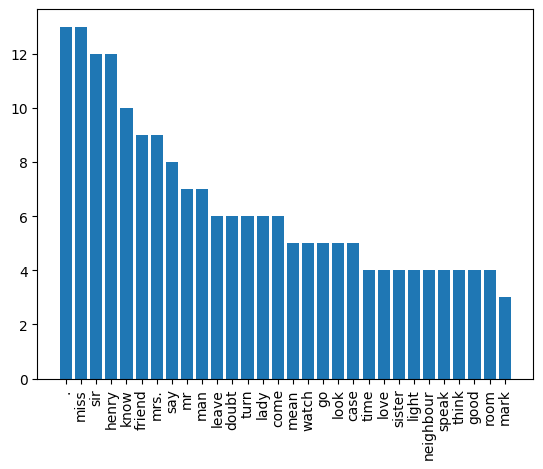

In [9]:
dict = count_occurences(find_groupings(raw_text, 'hope')) #a study in scarlet
dict = count_occurences(find_groupings(raw_text, 'lupin')) #arsene lupin versus sherlock holmes
dict = count_occurences(find_groupings(raw_text, 'stapleton')) #the hound of the baskervilles
dict = count_occurences(find_groupings(raw_text, 'priest')) #mystery of cloomber
dict = count_occurences(find_groupings(raw_text, 'small')) #the sign of four

# print(dict)

graph_occurences(dict)
